# **TP2 - CRÍTICAS CINEMATOGRÁFICAS - Blue Squad - Notebook Red Neuronal**

Integrantes:
- Franco Ricciardo Calderaro
- Matias Agustin Ferrero Cipolla
- Carlos Orqueda
- Sebastian Kraglievich


##Imports

In [ ]:
# No queremos ver la salida de pip
%%capture

%pip install langid
!pip install keras
!pip uninstall tensorflow -y
!pip install tensorflow
!pip install scikeras

In [ ]:
# Manipulacion y Visualizacion de datos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from collections import Counter
import joblib

#Libreria Procesamiento de Lenguaje Natural
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import scipy.stats as st
import langid

#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Red Neuronal
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
#from keras.wrappers.scikit_learn import KerasClassifier   #o Sci-Keras!!!
np.random.seed(1)
tf.random.set_seed(1)

#Modelos y métricas
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, precision_recall_curve, roc_auc_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [ ]:
criticas = pd.read_csv('./train.csv')
kaggle_test = pd.read_csv('./test.csv')

## Preprocesamiento

Arrancamos analizando el dataframe para identificar posibles datos faltantes.

In [ ]:
criticas.isna().sum()

ID             0
review_es      0
sentimiento    0
dtype: int64

Analizando la columna *sentimiento*, observamos que la variable toma dos valores: positivo y negativo.

Ademas podemos ver que se ambos valores son el 50% de la variable.

In [ ]:
criticas['sentimiento'].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

Para poder entrenar los modelos, modificamos la variable *sentimiento* para que tenga valores {Negativo = 0, Positivo = 1 }.

In [ ]:
criticas.replace(to_replace = {'negativo' : 0, 'positivo' : 1}, inplace = True)

Para asegurar que solo tengamos criticas en español, creamos una funcion que detecte el idioma en el que estan escritas y se la aplicamos a todas las filas del dataframe.

In [ ]:
def detect_language(text):
    return langid.classify(text)[0]

In [ ]:
criticas['language'] = criticas['review_es'].apply(detect_language)
criticas_spanish = criticas[criticas['language'] == 'es']
criticas_spanish.shape

(48179, 4)

Obtenemos una diferencia de 1821 criticas que son de otros idiomas, y eliminamos para quedarnos solo con las reseñas en español.

In [ ]:
criticas_spanish = criticas_spanish.drop(columns=['language'])
criticas = criticas_spanish.copy()

A continuacion, creamos una lista de la frecuencia de cada palabra en nuestro dataframe. Gracias a esto podemos identificar las palabras mas comunes y decidir cuales podemos filtrar para reducir la cantidad de variables en nuestro analisis.

Despuas de calcular la frecuencia de las palabras, evaluamos cuales pueden ser eliminadas. Las palabras mas frecuentes podrian ser consideradas como stopwords, mientras que las poco frecuentes podrian ser terminos irrelevantes.

Este proceso simplifica nuestro dataframe, y nos permite centrarnos en las palabras mas relevantes, facilitando la interpretacion de los resultados finales.

In [ ]:
# Combine all reviews into a single string
all_reviews = ' '.join(criticas['review_es'])
all_reviews = all_reviews.lower()

# Split the combined text into words using spaces, commas, and periods as delimiters
words = re.split(r'[\s,.()!?¿¡0123456789#$:;+*%&/={}"]', all_reviews)

# Remove empty strings resulting from splitting
words = [word for word in words if word]

# Count the frequency of each word using Counter
word_counts = Counter(words)

# Convert word_counts to a DataFrame
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['palabra', 'frecuencia'])
word_counts_df = word_counts_df.sort_values(by='frecuencia', ascending=False)

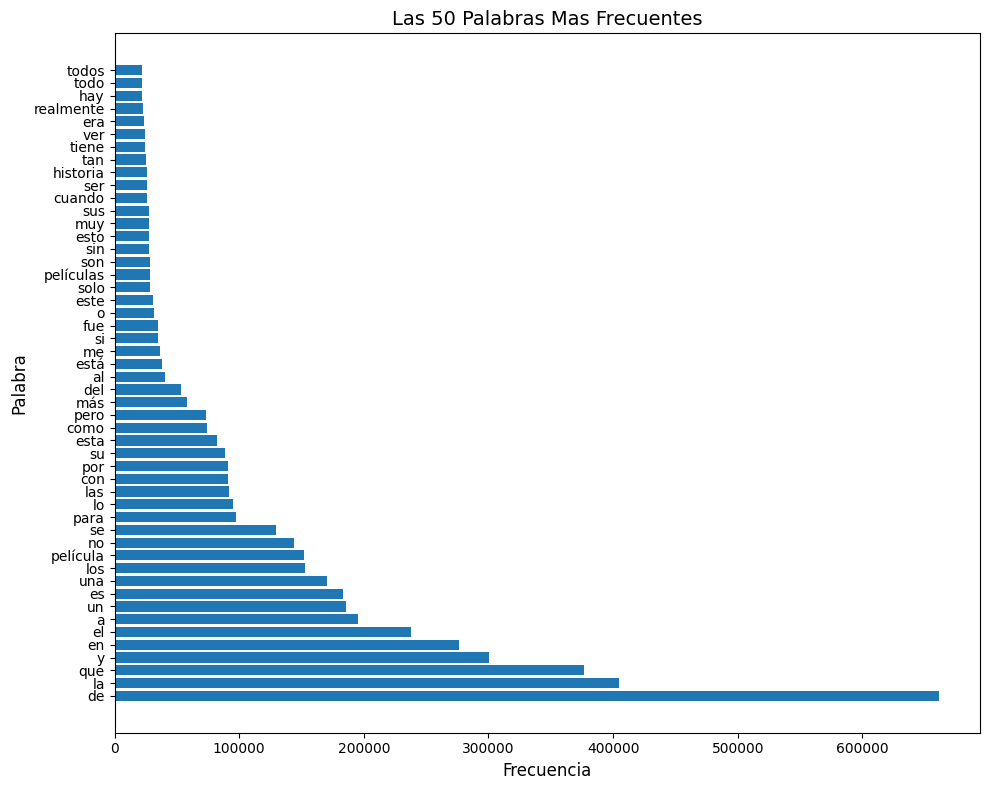

In [ ]:
plt.figure(figsize = (10, 8))
plt.barh(word_counts_df['palabra'][:50], word_counts_df['frecuencia'][:50])

plt.ylabel('Palabra', fontsize = 12)
plt.xlabel('Frecuencia', fontsize = 12)
plt.title('Las 50 Palabras Mas Frecuentes', fontsize = 14)
plt.yticks(fontsize = 10)

plt.tight_layout()
plt.show()

Observamos una marcada presencia de palabras repetidas, principalmente palabras funcionales (articulos, conjunciones, preposiciones), mientras que las palabras que no son consideradas palabras funcionales muestran una frecuencia más uniforme. Para mejorar el análisis, eliminamos las palabras funcionales identificadas hasta ahora, ya que no aportan informacion relevante.

También eliminamos numerosas palabras con una frecuencia igual a 1 que suelen ser inexistentes o no están relacionadas con el análisis de sentimientos, por lo que, tambien decidimos descartarlas del analisis.

### NLTK

Con NLTK (Natural Language Toolkit), preparamos nuestro dataset con procesos de preprocesamiento, simplificando nuestras variables para un análisis más efectivo. Para esto, realizamos:

*   __Tokenización__
*   __Eliminación de stopwords:__
*   __Lemmatization:__

In [ ]:
lemmatizer = WordNetLemmatizer()  # No hay lematizador específico en NLTK para español, pero usaremos uno general
stop_words = set(stopwords.words('spanish'))

def preprocesar_texto_lemm_regex(texto):

    # Reemplazar signos de puntuación por un espacio
    texto = re.sub(r'[^\w\s]', ' ', texto)

    # Eliminar cualquier secuencia de más de un espacio
    texto = re.sub(r'\s+', ' ', texto).strip()

    # Tokenizacion
    tokens = word_tokenize(texto.lower())

    # quitar stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lematización
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(tokens_lemmatized)

Tambien, hemos probado utilizar varios Regex, como por ejemplo, para eliminar caracteres especiales, diacriticos, signos de puntuacion, convertir todas las palabras a minisculas, etc. Sin embargo, los mejores resultados en Kaggle se siguen alcanzando con el `preprocesar_texto_lemm_regex` (con lemmatize de NTLK y 2 regex simples). Cuanto mas simple sea el análisis; mejor!

In [ ]:
criticas_filtradas = criticas.copy()
criticas_filtradas['processed_review'] = criticas_filtradas['review_es'].apply(preprocesar_texto_lemm_regex)

Como tenemos datos categóricos y nuestros modelos necesitan datos numéricos, vamos a utilizar un modelo para convertir palabras a vectores de números.

Y para poder mejorar el rendimiento en la competencia de kaggle, utilizamos el vocabulario del archivo de test, truncando aun mas que en otros modelos debido a la carga computacional de las redes.

Vamos a calcular las matrices de ocurrencias de términos usando sklearn.

El vectorizador seleccionado fue el siguiente:
- **TF-IDF**: calcula la frecuencia de cada termino por documento, y normaliza por el total de documentos donde el termino aparece.

In [ ]:
vectorizer_test = TfidfVectorizer(min_df = 10)
tfidf_test = vectorizer_test.fit_transform(kaggle_test.review_es)
tfidf_vectorizer = TfidfVectorizer(vocabulary = vectorizer_test.get_feature_names_out())

Por ultimo, generamos los conjuntos de train y test.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(criticas_filtradas.processed_review,
                                                    criticas_filtradas.sentimiento,
                                                    test_size = 0.3,
                                                    random_state = 2,
                                                    shuffle = True,
                                                    stratify = criticas_filtradas['sentimiento'].values)

Para terminar el preprocesamiento, configuramos los parametros del vectorizador con el vocabulario del test.

In [ ]:
tfidf_vectorizer.set_params(norm = 'l2', lowercase = False)

X_train_vectorizado_xl = tfidf_vectorizer.fit_transform(X_train)
X_test_vectorizado_xl = tfidf_vectorizer.transform(X_test)

##Red Neuronal

###Red

Para darle los datasets a las redes en un formato válido para ellas, los convertimos utilizando el metodo ``` .toarray() ```



In [ ]:
x_train_dense = X_train_vectorizado_xl.toarray()
x_test_dense = X_test_vectorizado_xl.toarray()

Comenzamos con un modelo básico con una entrada y salida de tamaño de uno, con un metodo de activacion 'sigmoid'

In [ ]:
d_in=x_train_dense.shape[1]

red_basic = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

red_basic.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 1)                   │           9,886 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,888 (38.62 KB)

 Trainable params: 9,888 (38.62 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
red_basic.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01),
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC'],
)

cant_epochs=100
modelo_red_basic = red_basic.fit(x_train_dense,y_train,
                                epochs=cant_epochs,
                                batch_size=50,verbose=False)

Luego de compilar la red creada, observemos su "Loss" con respecto al avance de las épocas

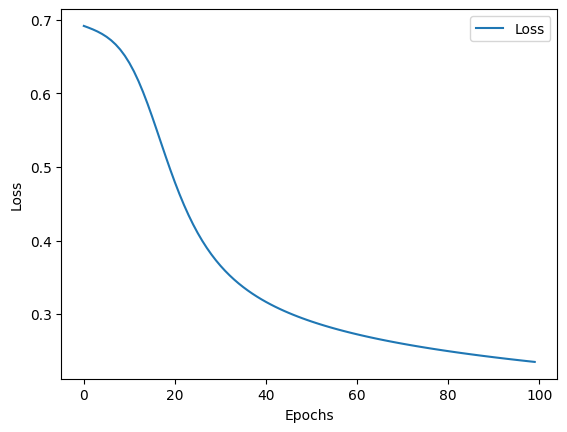

In [ ]:
plt.plot(modelo_red_basic.history["loss"], label = "Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

También, observemos la métrica seleccionada a lo largo de las épocas

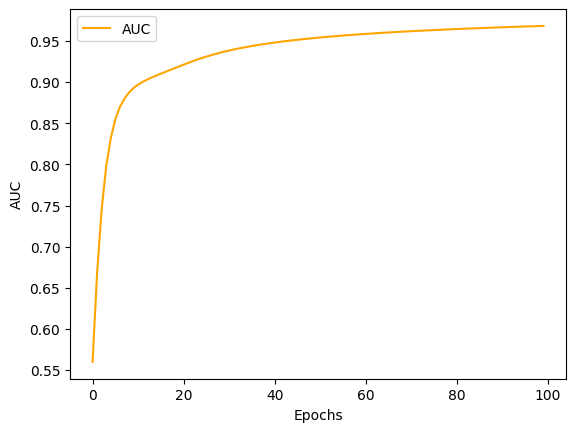

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, modelo_red_basic.history['AUC'], color='orange', label='AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend()

Aqui, realizamos la prediccion. Sin embargo, observamos dos posibilidades:

1.   Utilizar el round de numpy para que redondee las predicciones de la red
2.   Crear una funcion propia, donde podemos ir modificando y jugando con el umbral para tomar decisiones. Por ejemplo, una reseña que tiene un valor de sentimiento 0.45, o mas exacto aun, 0.4999. ¿Deberiamos considerarla negativa?


La primera opcion seria correr la siguiente línea de codigo:

```
y_predict = red_basic.predict(x_test_dense)
y_pred = np.round(y_predict)
```

Para la 2da, nos creamos la funcion asignar_clases

In [ ]:
def asignar_clases(predicciones, umbral):
    clases = [1 if nums >= umbral else 0 for nums in predicciones]
    return clases

Utilizaremos la 2da opcion ya que hemos tenido mejores resultados

In [ ]:
y_predict = red_basic.predict(x_test_dense)

# Asignamos clases a las predicciones
y_pred = asignar_clases(y_predict, 0.5)

452/452 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Graficamos la matriz de confusion para observar mejor que paso. Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      7239
           1       0.86      0.89      0.88      7215

    accuracy                           0.87     14454
   macro avg       0.87      0.87      0.87     14454
weighted avg       0.87      0.87      0.87     14454



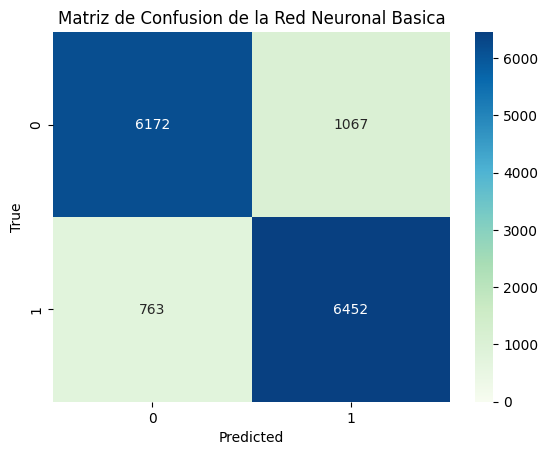

In [ ]:
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion de la Red Neuronal Basica')

print(classification_report(y_test, y_pred))
plt.show()

Para respaldar el grafico calculamos las metricas en el conjunto de evaluacion.


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8733914487339145
Recall: 0.8942480942480943
Precision: 0.8580928314935496
f1 score: 0.8757974752273653


###Randomized Search CV

Realizamos KFOLD CV Random Search para buscar los mejores hiperparametros del modelo con el siguiente codigo.

Como es un Random Search que devuelve distintos valores cada vez que se corre, y además tarda mucho tiempo, lo dejamos en formato texto. Incluso en el caso de las redes, la notebook de colab termina colapsando ya sea porque se consume la RAM o porque deja de funcionar la página. Por ende, fue muy dificil jugar con este Cross Validation.

Si se desea correr el Random Search CV, basta con copiar el codigo de abajo en un bloque de codigo y correrlo.

Este para crear la funcion que crea, compila una red y la devuelve:
```
d_in=x_train_dense.shape[1]

# Create the sklearn model for the network
def create_model():
    modelo= keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,)),
    keras.layers.Dense(1, activation='sigmoid')])

    modelo.compile(
      optimizer=keras.optimizers.SGD(learning_rate=0.001),
      loss='binary_crossentropy',
      # metricas para ir calculando en cada iteracion o batch
      metrics=['AUC'],
    )

    return modelo
```



Este para correr el Random Search CV
```
#Cantidad de combinaciones que quiero probar
n=2

#Conjunto de parámetros que quiero usar
epochs = [50, 80, 100]
batches = [10, 30, 50]

param_grid = dict(epochs=epochs, batch_size=batches)

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
modelo_cv = KerasClassifier(build_fn=create_model)

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=modelo_cv,
                            param_distributions = param_grid,
                            scoring=scorer_fn,
                            cv=kfoldcv,
                            n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
random_result = randomcv.fit(x_train_dense, y_train)

# Obtener los mejores parámetros y puntuación
print("Mejores hiperparámetros:", random_result.best_params_)
print("Y su puntuacion es:", random_result.best_score_)
```



Ademas, si se quiere predecir el modelo con los hiperparametros obtenidos, se puede correr el siguiente codigo copiandolo en un bloque de codigo.

```
#Obtenemos el mejor modelo
red_cv_best = randomcv.best_estimator_

#Predicción
y_predict = red_cv_best.predict(x_test_dense)

#Si quiere redondear los datos de salida:
y_pred = np.round(y_pred)

# Si quiere asignar clases a las predicciones mediante un umbral determinado:
y_pred = asignar_clases(y_predict, 0.5)
```

Para terminar, si se quieren obtener las metricas del modelo obtenido dejamos el siguiente codigo para copiar a un bloque de codigo.

Recordemos que las categorías de *sentimiento* son:

*   0 = Negativo
*   1 = Positivo



```
tabla = confusion_matrix(y_test, y_pred)

sns.heatmap(tabla, cmap = 'GnBu', annot = True, fmt = 'g', vmin = 0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusion de la Red Neuronal')

plt.show()
print("\n",classification_report(y_test, y_pred))
```



```
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))
```

##Kaggle Test

In [ ]:
kaggle_filtrado = kaggle_test.copy()
kaggle_filtrado['processed_review'] = kaggle_filtrado['review_es'].apply(preprocesar_texto_lemm_regex)

Si corriste el Random Search Cross Validation, puede ejecutar este cuadro de codigo:


```
y_pred_kaggle = red_cv_best.predict(kaggle_filtrado['processed_review'])
```



En su defecto, si se creo una Red, ejecute este otro cuadro de codigo:

In [ ]:
kaggle_test_vectorizado = tfidf_vectorizer.transform(kaggle_filtrado['processed_review'])
kaggle_test_dense = kaggle_test_vectorizado.toarray()

Aqui, realizamos la prediccion. Sin embargo, recordemos las dos posibilidades:

1.   Utilizar el round de numpy para que redondee las predicciones de la red
2.   Utilizar la funcion propia "asignar_clase", donde podemos ir modificando y jugando con el umbral para tomar decisiones

Recordamos que con la 2da opción, hemos tenido mejores resultados

In [ ]:
y_predict_kaggle = red_basic.predict(kaggle_test_dense)
y_pred_kaggle = asignar_clases(y_predict_kaggle, 0.3)

269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


###Exportamos el CSV para subirlo a Kaggle

In [ ]:
submit = pd.DataFrame(zip(kaggle_test['ID'], y_pred_kaggle), columns = ['ID' , 'sentimiento'])
submit['sentimiento'].replace(to_replace = {0 : 'negativo', 1 : 'positivo'}, inplace = True)

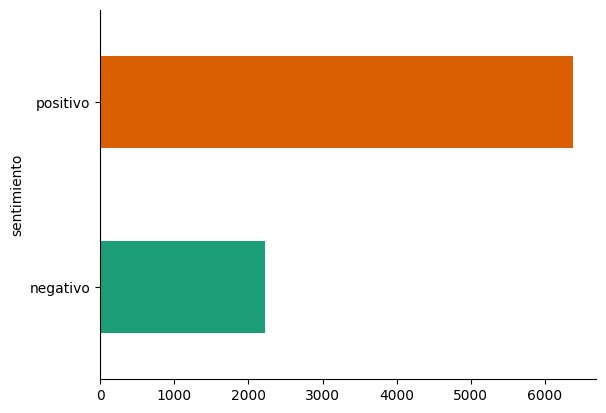

In [ ]:
submit.groupby('sentimiento').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ruta_archivo = '/content/RED-21.csv'
submit.to_csv(ruta_archivo, index=False)

Para terminar con el modelo, lo guardamos en un archivo Joblib.

In [ ]:
joblib.dump(red_basic, 'mejor_red.joblib')

['mejor_red.joblib']